# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import h5py
import ismrmrd
import matplotlib.pyplot as plt
import torch

from juart.conopt.functional.fourier import fourier_transform_adjoint
from juart.preproc.data import KSpaceData, get_shape
from juart.preproc.trajectory import KSpaceTrajectory

torch.set_num_threads(1)

In [2]:
fname = "7T1566"
# fname = "7T1026"

In [3]:
save = False
pulseq = True

In [4]:
full_session_dir = "/home/projects/qrage/sessions/%s" % fname
h5_ismrmrd_fname = "ismrmrd/mz_me_mpnrage3d.h5"
h5_preproc_fname = "preproc/mz_me_mpnrage3d_grappa_pytorch.h5"

In [5]:
full_h5_ismrmrd_fname = os.path.join(full_session_dir, h5_ismrmrd_fname)
full_h5_preproc_fname = os.path.join(full_session_dir, h5_preproc_fname)

In [6]:
print(full_h5_ismrmrd_fname)
print(full_h5_preproc_fname)

/home/projects/qrage/sessions/7T1566/ismrmrd/mz_me_mpnrage3d.h5
/home/projects/qrage/sessions/7T1566/preproc/mz_me_mpnrage3d_grappa_pytorch.h5


# Load Data

In [7]:
print("(1/2) Loading rawdata ...")

(1/2) Loading rawdata ...


In [8]:
dataset = ismrmrd.Dataset(
    full_h5_ismrmrd_fname,
    dataset_name="dataset",
    create_if_needed=False,
)

In [9]:
NCha, NCol, NLin, NPar, NSli, NSet, NEco = get_shape(dataset)

In [10]:
# For now, manually set this to 160
NPar = 160

In [11]:
print(NCha, NCol, NLin, NPar, NSli, NSet, NEco)

32 256 128 160 1 2 2


In [12]:
NLin_retro = 128
# NLin_retro = NLin
NPar_post, NSli_post = NSli, NPar
NCha_comp, ISet_comp, IEco_comp = 8, slice(NSet - 1, NSet), slice(0, 1)
NImx, NImy, ISet_coil, IEco_coil = 256, 256, slice(15, 19), slice(0, 1)
NAcl, NUsf = 32, 2

In [13]:
kdata = KSpaceData((NCha, NCol, NLin, NPar, NSli, NSet, NEco))

In [14]:
kdata.read_data(dataset, is_pulseq=pulseq)

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=47191) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/49152 [00:00<?, ?it/s]

In [15]:
# Undersample along line dimension
kdata.index_data([slice(None), slice(None), slice(NLin_retro), ...])

/opt/conda/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


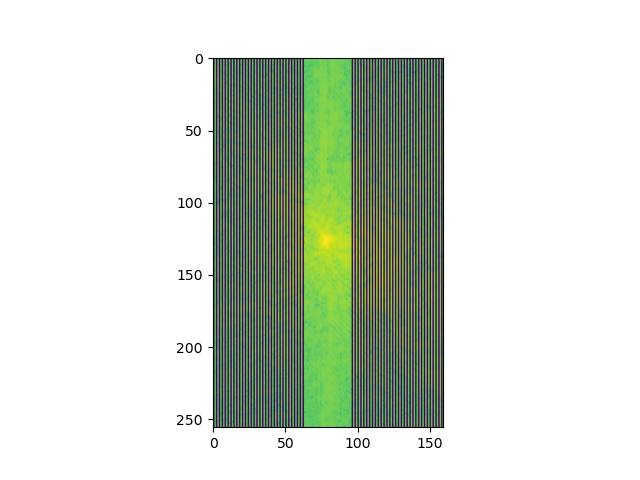

In [16]:
plt.figure()
plt.imshow(torch.log(torch.abs(kdata.kdata[0, :, 0, :, 0, 0, 0]) + 1e-16).numpy())

# GRAPPA

In [17]:
kdata.apply_mask(NUsf, NAcl, is_pulseq=pulseq)

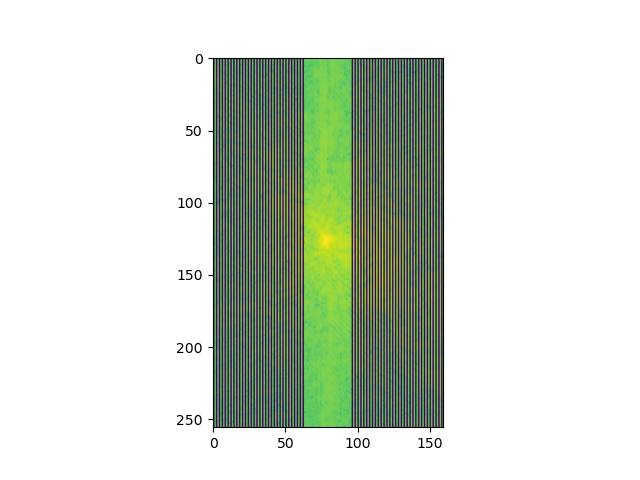

In [18]:
plt.figure()
plt.imshow(torch.log(torch.abs(kdata.kdata[0, :, 0, :, 0, 0, 0]) + 1e-16).numpy())

In [19]:
kdata.reconstruct_partitions()

  0%|          | 0/512 [00:00<?, ?it/s]

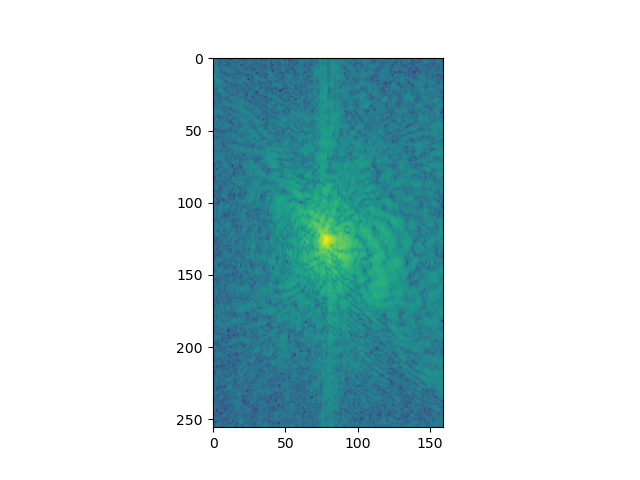

In [20]:
plt.figure()
plt.imshow(torch.log(torch.abs(kdata.kdata[0, :, 0, :, 0, 0, 0]) + 1e-16).numpy())

# Coil compression

In [21]:
# Swap Par and Sli Partition
kdata.swapaxes(3, 4)

In [22]:
comp_matrix = kdata.compression_matrix(NCha_comp, ISet_comp, IEco_comp)

In [23]:
print(comp_matrix.shape)

torch.Size([8, 32, 160])


In [24]:
kdata.compress_data(comp_matrix)

  0%|          | 0/512 [00:00<?, ?it/s]

In [25]:
# Swap Col and Lin dimension
kdata.swapaxes(1, 2)

In [26]:
print(kdata.kdata_shape)

torch.Size([8, 128, 256, 1, 160, 2, 2])


In [27]:
NCha, NLin, NCol, NPar, NSli, NSet, NEco = kdata.kdata_shape

In [28]:
print("(4/4) Creating output file ....")

if save:
    with h5py.File(full_h5_preproc_fname, "w", libver="latest") as out_file:
        out_file.create_dataset(
            "d", data=kdata.kdata.numpy(), chunks=(NCha, NLin, NCol, 1, 1, 1, 1)
        )

(4/4) Creating output file ....


(np.float64(-0.5), np.float64(255.5), np.float64(159.5), np.float64(-0.5))

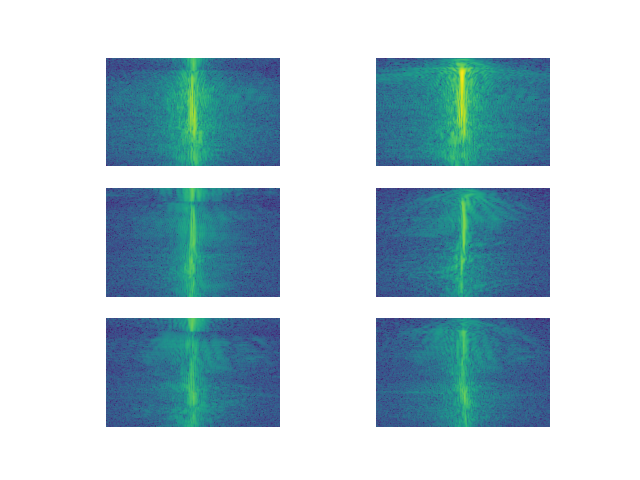

In [29]:
plt.figure()
plt.subplot(3, 2, 1)
plt.imshow(
    torch.log(torch.abs(kdata.kdata[0, 0, :, 0, :, 0, 0].T)).numpy(), vmin=-16, vmax=-7
)
plt.axis("off")
plt.subplot(3, 2, 2)
plt.imshow(
    torch.log(torch.abs(kdata.kdata[-1, 0, :, 0, :, 0, 0].T)).numpy(), vmin=-16, vmax=-7
)
plt.axis("off")
plt.subplot(3, 2, 3)
plt.imshow(
    torch.log(torch.abs(kdata.kdata[0, 1, :, 0, :, 0, 0].T)).numpy(), vmin=-16, vmax=-7
)
plt.axis("off")
plt.subplot(3, 2, 4)
plt.imshow(
    torch.log(torch.abs(kdata.kdata[-1, 1, :, 0, :, 0, 0].T)).numpy(), vmin=-16, vmax=-7
)
plt.axis("off")
plt.subplot(3, 2, 5)
plt.imshow(
    torch.log(torch.abs(kdata.kdata[0, 2, :, 0, :, 0, 0].T)).numpy(), vmin=-16, vmax=-7
)
plt.axis("off")
plt.subplot(3, 2, 6)
plt.imshow(
    torch.log(torch.abs(kdata.kdata[-1, 2, :, 0, :, 0, 0].T)).numpy(), vmin=-16, vmax=-7
)
plt.axis("off")

In [30]:
vmax = 5e-4

(np.float64(-0.5), np.float64(255.5), np.float64(159.5), np.float64(-0.5))

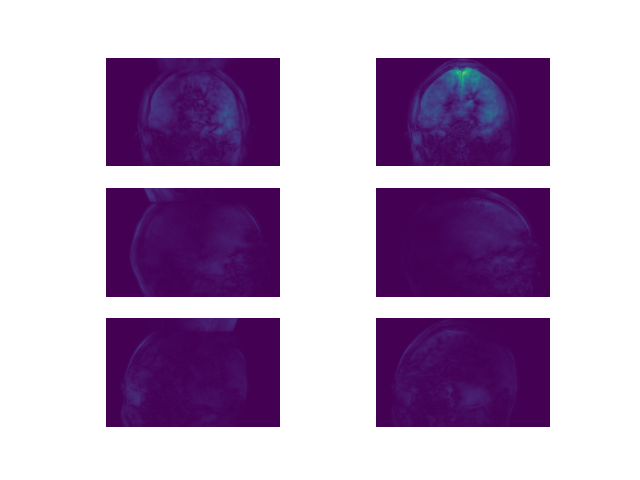

In [31]:
plt.figure()
plt.subplot(3, 2, 1)
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[0, 0, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=vmax,
)
plt.axis("off")
plt.subplot(3, 2, 2)
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[-1, 0, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=vmax,
)
plt.axis("off")
plt.subplot(3, 2, 3)
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[0, 1, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=vmax,
)
plt.axis("off")
plt.subplot(3, 2, 4)
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[-1, 1, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=vmax,
)
plt.axis("off")
plt.subplot(3, 2, 5)
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[0, 2, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=vmax,
)
plt.axis("off")
plt.subplot(3, 2, 6)
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[-1, 2, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=vmax,
)
plt.axis("off")

# Gradient Delay Correction (RING)

In [32]:
ktraj = KSpaceTrajectory(NLin, NCol, NSet, NEco)

In [33]:
S_corr = ktraj.estimate_gradient_delay(kdata.kdata)

In [34]:
S_corr

tensor([[-1.9915e-01, -1.9590e-01, -2.5842e-04],
        [-5.0376e-01, -5.0030e-01,  7.0785e-03]], dtype=torch.float64)

In [35]:
ktraj_corr = ktraj.correct_kspace_trajectory(S_corr)

In [36]:
if save:
    with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
        dset = h5_preproc_file.create_dataset(
            "k", data=ktraj_corr.numpy(), chunks=(2, NLin_retro, NCol, 1, 1, 1, 1)
        )

# Coil Sensitivity Estimation (SAKE + ESPIRiT)

In [37]:
sensmaps = kdata.get_sensmaps(ktraj_corr, (NCha, NImx, NImy, 1, NSli, 1, 1), multi_contrast=False)

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=47191) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/160 [00:00<?, ?it/s]

In [38]:
print(sensmaps.shape)

torch.Size([8, 256, 256, 1, 160, 1, 1])


In [39]:
if save:
    with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
        dset = h5_preproc_file.create_dataset(
            "C",
            data=sensmaps.numpy(),
            chunks=(NCha_comp, NImx, NImy, NPar_post, NSli_post, 1, 1),
        )

/opt/conda/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


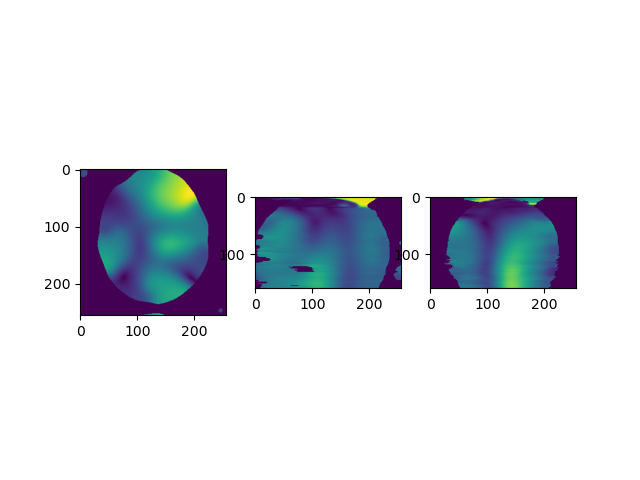

In [40]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(torch.abs(sensmaps[0, :, :, 0, 80, 0, 0]).numpy())
plt.subplot(1, 3, 2)
plt.imshow(torch.abs(sensmaps[0, :, 128, 0, :, 0, 0]).T.numpy())
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(sensmaps[0, 128, :, 0, :, 0, 0]).T.numpy())

(np.float64(-0.5), np.float64(255.5), np.float64(159.5), np.float64(-0.5))

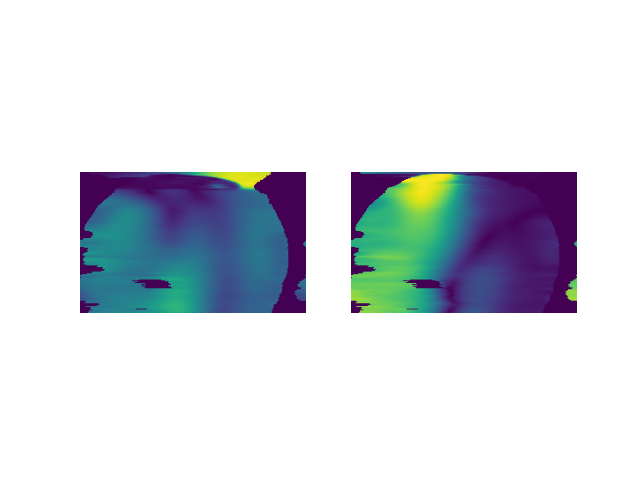

In [41]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(torch.abs(sensmaps[0, :, 128, 0, :, 0, 0].T).numpy(), vmin=0, vmax=1)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(torch.abs(sensmaps[-1, :, 128, 0, :, 0, 0].T).numpy(), vmin=0, vmax=1)
plt.axis("off")